In [1]:
# Imports
import os
import logging
import tempenv

import matplotlib.pyplot as plt

from sertit import logs

from eoreader.reader import Reader
from eoreader.bands import DEM, SLOPE, HILLSHADE, VV, RED
from eoreader.env_vars import DEM_PATH, SNAP_DEM_NAME
from eoreader.keywords import DEM_KW, SLOPE_KW, HILLSHADE_KW
from eoreader.products import SnapDems 

# Create logger
logger = logging.getLogger("eoreader")
logs.init_logger(logger)

In [2]:
# Open the product
path = os.path.join("/home", "data", "DATA", "PRODS", "S2", "PB 02.07+", "S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749.SAFE")
prod = Reader().open(path)

In [3]:
# DEM paths
dem_folder = os.path.join("/home", "data", "DS2", "BASES_DE_DONNEES", "GLOBAL")
dtm = os.path.join(dem_folder, "MERIT_Hydrologically_Adjusted_Elevations", "MERIT_DEM.vrt")
dem = os.path.join(dem_folder, "COPDEM_30m", "COPDEM_30m.vrt")
dem_tif = os.path.join(dem_folder, "EUDEM_v2", "eudem_wgs84.tif")

In [4]:
# Error when computing the DEM band: Iy hasn't been specified it
try:
    prod.load(DEM)[DEM]
except ValueError as msg:
   logger.error(msg)     

2022-05-27 12:36:16,731 - [ERROR] - DEM path not set, unable to compute DEM bands! Please set the environment variable EOREADER_DEM_PATH or a DEM keyword.


In [5]:
# This works now
with tempenv.TemporaryEnvironment({DEM_PATH: dem}):
    prod.load(DEM)[DEM]

2022-05-27 12:36:16,742 - [DEBUG] - Loading DEM bands ['DEM']


2022-05-27 12:36:16,743 - [DEBUG] - Warping DEM for 20200114T065229_S2_T40REQ_L2A_094749


2022-05-27 12:36:16,746 - [DEBUG] - Using DEM: /home/data/DS2/BASES_DE_DONNEES/GLOBAL/COPDEM_30m/COPDEM_30m.vrt


In [6]:
dem_bands = prod.load(
    [DEM, SLOPE, HILLSHADE], 
    **{
        DEM_KW: dem,
        SLOPE_KW: dtm, # We want a DTM here
        HILLSHADE_KW: dem,        
    }
)

2022-05-27 12:36:21,383 - [DEBUG] - Loading DEM bands ['SLOPE', 'HILLSHADE', 'DEM']


2022-05-27 12:36:21,384 - [DEBUG] - Warping DEM for 20200114T065229_S2_T40REQ_L2A_094749


2022-05-27 12:36:21,387 - [DEBUG] - Using DEM: /home/data/DS2/BASES_DE_DONNEES/GLOBAL/MERIT_Hydrologically_Adjusted_Elevations/MERIT_DEM.vrt


2022-05-27 12:36:22,881 - [DEBUG] - Computing slope for 20200114T065229_S2_T40REQ_L2A_094749


2022-05-27 12:36:30,131 - [DEBUG] - Already existing DEM for 20200114T065229_S2_T40REQ_L2A_094749. Skipping process.


2022-05-27 12:36:30,132 - [DEBUG] - Computing hillshade DEM for S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749


2022-05-27 12:36:39,224 - [DEBUG] - Already existing DEM for 20200114T065229_S2_T40REQ_L2A_094749. Skipping process.


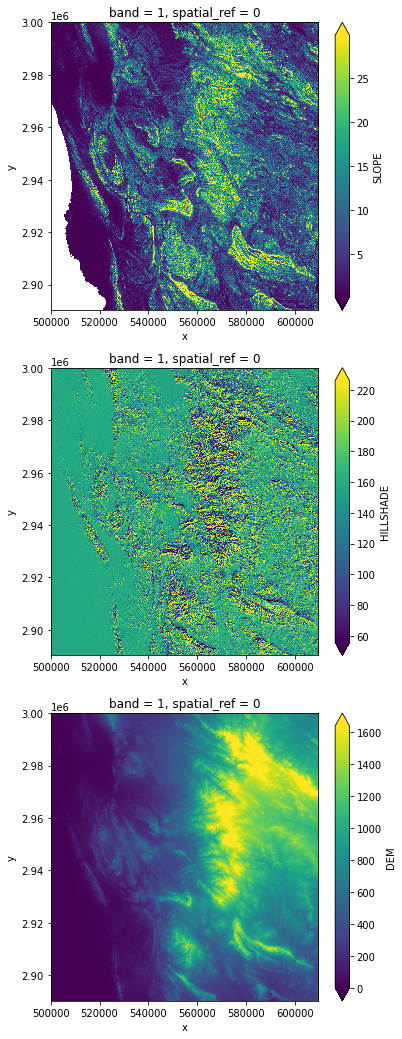

In [7]:
# Plot DEM bands
ncols = len(dem_bands)
plt.figure(figsize=(6, 6 * ncols))
i = 0
for key in dem_bands.keys():
    axes = plt.subplot(3, 1, i+1)
    dem_bands[key][0, ::10, ::10].plot.imshow(robust=True)
    i += 1

In [8]:
# Open a SAR product
path = os.path.join("/home", "data", "DATA", "PRODS", "S1", "S1B_IW_GRDH_1SDV_20191215T180300_20191215T180325_019379_0249B2_C99C.SAFE")
prod = Reader().open(path)

2022-05-27 12:36:42,394 - [DEBUG] - Pre-process SAR image


SNAP Release version 8.0
SNAP home: /opt/snap/bin/..
SNAP debug: null
SNAP log level: WARNING
Java home: /opt/snap/jre/jre
Java version: 1.8.0_242
Processors: 16
Max memory: 40.9 GB
Cache size: 23.0 GB
Tile parallelism: 14
Tile size: 2048 x 2048 pixels

To configure your gpt memory usage:
Edit snap/bin/gpt.vmoptions

To configure your gpt cache size and parallelism:
Edit .snap/etc/snap.properties or gpt -c ${cachesize-in-GB}G -q ${parallelism} 


Executing processing graph


OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_POEORB AND beginposition:[2019-12-01T00:00:000Z TO 2019-12-31T24:00:000Z]


OpenSearch: 31 total results on 1 pages.
OpenSearch: https://scihub.copernicus.eu/gnss/search?q=platformname:Sentinel-1 AND platformnumber:B AND producttype:AUX_POEORB AND beginposition:[2019-12-01T00:00:000Z TO 2019-12-31T24:00:000Z]


version = 3.1


10%20%30%40%50%60%70%.80%90%

Copernicus_DSM_COG_10_N44_00_W005_00_DEM.tif


Copernicus_DSM_COG_10_N44_00_W004_00_DEM.tif
Copernicus_DSM_COG_10_N44_00_W003_00_DEM.tif


Copernicus_DSM_COG_10_N44_00_W002_00_DEM.tif


Copernicus_DSM_COG_10_N44_00_W001_00_DEM.tif


Copernicus_DSM_COG_10_N43_00_W001_00_DEM.tif


Copernicus_DSM_COG_10_N43_00_W005_00_DEM.tif


Copernicus_DSM_COG_10_N43_00_W004_00_DEM.tif


Copernicus_DSM_COG_10_N43_00_W003_00_DEM.tif


Copernicus_DSM_COG_10_N43_00_W002_00_DEM.tif


Copernicus_DSM_COG_10_N42_00_W001_00_DEM.tif


Copernicus_DSM_COG_10_N42_00_W002_00_DEM.tif


Copernicus_DSM_COG_10_N42_00_W005_00_DEM.tif


Copernicus_DSM_COG_10_N42_00_W004_00_DEM.tif


Copernicus_DSM_COG_10_N42_00_W003_00_DEM.tif


 done.


2022-05-27 12:39:51,388 - [DEBUG] - Converting DIMAP to GeoTiff


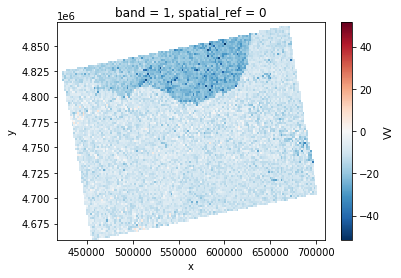

In [9]:
# Orthorectifying with COPDEM-30
vv = prod.load(VV, resolution=prod.resolution*100)[VV]
vv.plot()

2022-05-27 12:39:56,607 - [DEBUG] - Pre-process SAR image


SNAP Release version 8.0
SNAP home: /opt/snap/bin/..
SNAP debug: null
SNAP log level: WARNING
Java home: /opt/snap/jre/jre
Java version: 1.8.0_242
Processors: 16
Max memory: 40.9 GB
Cache size: 23.0 GB
Tile parallelism: 14
Tile size: 2048 x 2048 pixels

To configure your gpt memory usage:
Edit snap/bin/gpt.vmoptions

To configure your gpt cache size and parallelism:
Edit .snap/etc/snap.properties or gpt -c ${cachesize-in-GB}G -q ${parallelism} 


Executing processing graph


version = 3.1


10%20%30%40%50%60%70%.80%90%

2022-05-27 12:41:05,104 - [DEBUG] - Converting DIMAP to GeoTiff


 done.


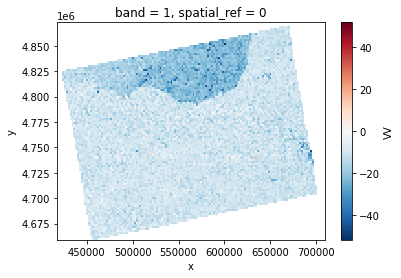

In [10]:
# Orthorectifying with GETASSE
prod.clean_tmp()
with tempenv.TemporaryEnvironment(
    {
        SNAP_DEM_NAME: SnapDems.GETASSE30.value
    }
):
    vv2 = prod.load(VV, resolution=prod.resolution*100)[VV]
    vv2.plot()

In [11]:
# Open a VHR product in sensor geometry
path = os.path.join("/home", "data", "DATA", "PRODS", "PLEIADES", "3302499201", "IMG_PHR1A_MS_004")
prod = Reader().open(path)

In [12]:
# Error when orthorectifying the RED band: Iy hasn't been specified it
try:
    prod.load(RED)[RED]
except ValueError as msg:
   logger.error(msg)

2022-05-27 12:41:06,265 - [DEBUG] - Loading bands ['RED']


2022-05-27 12:41:06,267 - [INFO] - Manually orthorectified stack not given by the user. Reprojecting whole stack, this may take a while. (May be inaccurate on steep terrain, depending on the DEM resolution)


2022-05-27 12:41:06,268 - [ERROR] - As you are using a non orthorectified VHR product (/home/data/DATA/PRODS/PLEIADES/3302499201/IMG_PHR1A_MS_004), you must provide a valid DEM through the EOREADER_DEM_PATH environment variable


2022-05-27 12:41:06,276 - [DEBUG] - Loading bands ['RED']


2022-05-27 12:41:06,277 - [INFO] - Manually orthorectified stack not given by the user. Reprojecting whole stack, this may take a while. (May be inaccurate on steep terrain, depending on the DEM resolution)


2022-05-27 12:41:07,825 - [DEBUG] - Orthorectifying data with /home/data/DS2/BASES_DE_DONNEES/GLOBAL/COPDEM_30m/COPDEM_30m.vrt


2022-05-27 12:42:47,787 - [DEBUG] - Read RED


2022-05-27 12:42:48,834 - [DEBUG] - Converting RED to reflectance


2022-05-27 12:42:48,923 - [DEBUG] - Manage nodata for band RED


2022-05-27 12:42:48,990 - [INFO] - Orthorectifying ROI


2022-05-27 12:42:49,042 - [DEBUG] - 	Rasterizing ROI


2022-05-27 12:42:49,074 - [DEBUG] - 	Reprojecting ROI


2022-05-27 12:42:49,075 - [DEBUG] - Orthorectifying data with /home/data/DS2/BASES_DE_DONNEES/GLOBAL/COPDEM_30m/COPDEM_30m.vrt


2022-05-27 12:44:13,745 - [DEBUG] - 	Revectorizing ROI


/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


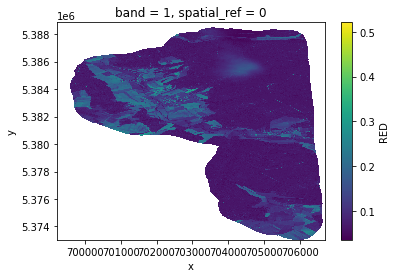

In [13]:
# With environment variable
with tempenv.TemporaryEnvironment({DEM_PATH: dem}):
    red = prod.load(RED)[RED]

red.plot()